In [ ]:
from pystac_client import Client
import geopandas as gpd
from datetime import datetime, UTC
import stackstac
import xarray as xr
from shapely.geometry import Point
from rasterio.errors import RasterioIOError
from planetary_computer import sign_inplace
import matplotlib.pyplot as plt
import sentinel2indices as s2i
from skimage.exposure import match_histograms
import math
from dask.diagnostics import ProgressBar
import rioxarray
import os
import hashlib
import pickle
from tqdm import tqdm
import numpy as np

In [ ]:

### CELL 1 Load Data

# Connect to Planetary Computer STAC
stac = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")

# Load AOI from GeoJSON file
aoi_path = '/Users/thowe/MinersAI Dropbox/Tyler Howe/Sibelco_Stuff/DATACUBE/sibelco_ML_pilot_region.geojson'
aoi_gdf = gpd.read_file(aoi_path)

# Reproject to WGS84 if needed
if aoi_gdf.crs != "EPSG:4326":
    aoi_gdf = aoi_gdf.to_crs("EPSG:4326")

aoi_gdf.plot()


In [ ]:

### CELL 2 Search STAC for low-cloud Sentinel-2 L2A items over AOI

# Broad date range — Sentinel-2 L2A available since mid-2017
start_date = "2017-06-28"
end_date = datetime.now(UTC).date().isoformat()

# Query STAC for clean Sentinel-2 L2A items
search = stac.search(
    collections=["sentinel-2-l2a"],
    intersects=aoi_gdf.geometry[0].__geo_interface__,
    datetime=f"{start_date}/{end_date}",
    query={"eo:cloud_cover": {"lt": 10}},  # low-cloud only
    sortby=["eo:cloud_cover"],  # sort by best quality
)

items = list(search.items())
print(f"Found {len(items)} items")


In [ ]:
### CELL 3: Setup caching system
# Create cache directory
cache_dir = '/Users/thowe/sentinel2_cache'
os.makedirs(cache_dir, exist_ok=True)

def create_cache_key(s2a_items, aoi_bounds, epsg):
    """Create a unique cache key based on input parameters"""
    key_data = {
        'item_ids': [item.id for item in s2a_items],
        'bounds': aoi_bounds.tolist(),
        'epsg': epsg,
        'bands': ["B01", "B02", "B03", "B04", "B06", "B07", "B08", "B8A", "B11", "B12"]
    }
    key_str = str(sorted(key_data.items()))
    return hashlib.md5(key_str.encode()).hexdigest()

def save_to_cache(data, cache_key, cache_dir):
    """Save processed data to cache"""
    cache_path = os.path.join(cache_dir, f"{cache_key}_composite.nc")
    print(f"Saving composite to cache: {cache_path}")
    # Use smaller chunks for saving
    data_chunked = data.chunk({"band": 1, "y": 512, "x": 512})
    with ProgressBar():
        data_chunked.to_netcdf(cache_path)
    return cache_path

def load_from_cache(cache_key, cache_dir):
    """Load processed data from cache"""
    cache_path = os.path.join(cache_dir, f"{cache_key}_composite.nc")
    if os.path.exists(cache_path):
        print(f"Loading composite from cache: {cache_path}")
        ds = xr.open_dataset(cache_path, chunks={"y": 512, "x": 512})
        # Collapse all data_vars into one DataArray along "band"
        arr = ds.to_array(dim="band")
        return arr
    return None

In [ ]:
### CELL 4: Filter for S2A scenes and determine EPSG
# Keep only S2A scenes (limit to avoid memory issues)
s2a_items = [it for it in items if it.id.startswith("S2A")][:10]  # Reduced from 20 to 10
if not s2a_items:
    raise RuntimeError("No S2A scenes found—check your STAC search criteria.")

print("Signing URLs...")
for it in tqdm(s2a_items, desc="Signing items"):
    sign_inplace(it)

print("Using these S2A items:", [it.id for it in s2a_items])

# Try EPSG from first item
item0 = s2a_items[0]
epsg = None
try:
    epsg = item0.assets["B02"].extra_fields["proj:epsg"]
    print(f"Using EPSG from first item: {epsg}")
except KeyError:
    pass

# Fall back to AOI centroid
if epsg is None:
    centroid: Point = aoi_gdf.geometry[0].centroid
    lon, lat = centroid.x, centroid.y
    zone = int((lon + 180) / 6) + 1
    epsg = 32600 + zone if lat >= 0 else 32700 + zone
    print(f"Using EPSG from AOI centroid: {epsg}")

In [ ]:
### CELL 5: Process & cache raw histogram-matched stack
# Create base cache key and derive a raw-stack key
base_key = create_cache_key(s2a_items, aoi_gdf.total_bounds, epsg)
raw_cache_key = f"{base_key}_raw"

print(f"Cache key for raw stack: {raw_cache_key}")
raw_stack = load_from_cache(raw_cache_key, cache_dir)

if raw_stack is not None:
    raw_stack = raw_stack.rio.write_crs(f"EPSG:{epsg}")
    print("✅ Loaded raw histogram-matched stack from cache!")
else:
    print("❌ No cached raw stack found. Processing raw data from scratch...")

    # Build initial 10 m stack with smaller chunks
    print("Creating initial stack…")
    stack = stackstac.stack(
        s2a_items,
        assets=["B01","B02","B03","B04","B06","B07","B08","B8A","B11","B12","SCL"],
        resolution=10,
        epsg=epsg,
        chunksize=1024,  # Reduced from 2048
        bounds_latlon=aoi_gdf.total_bounds,
        dtype="float64",  # Keep float64 for rescaling compatibility
        rescale=True,
        errors_as_nodata=[RasterioIOError, RuntimeError],
    )
    print("Stack shape:", stack.shape)

    # Rechunk for per-scene processing
    print("Rechunking data…")
    stack_small = stack.chunk({"band": -1, "y": 512, "x": 512, "time": 1})  # Smaller chunks
    ref_bands = ["B01","B02","B03","B04","B06","B07","B08","B8A","B11","B12"]
    ref = stack_small.isel(time=0).sel(band=ref_bands).chunk({"band": -1, "y": 512, "x": 512})

    # Define histogram-matching UFunc
    def match_to_ref(scene, ref):
        return xr.apply_ufunc(
            match_histograms,
            scene, ref,
            input_core_dims=[["band","y","x"],["band","y","x"]],
            output_core_dims=[["band","y","x"]],
            vectorize=True,
            dask="parallelized",
            output_dtypes=[scene.dtype],
            dask_gufunc_kwargs={
                "allow_rechunk": True,
                "output_sizes": {"band": scene.sizes["band"], "y": scene.sizes["y"], "x": scene.sizes["x"]},
            },
        )

    # Apply histogram matching to each scene
    print("Histogram matching scenes…")
    matched = []
    for i, t in enumerate(tqdm(stack_small.time.values, desc="Processing scenes")):
        scene = stack_small.isel(time=i).sel(band=ref.band).chunk({"band": -1, "y": 512, "x": 512})
        m = match_to_ref(scene, ref).expand_dims(time=[t])
        matched.append(m)

    stack_norm = xr.concat(matched, dim="time")

    # Compute raw stack in chunks
    print("Computing full raw stack…")
    stack_norm = stack_norm.chunk({"time": 1, "band": -1, "y": 512, "x": 512})
    with ProgressBar():
        raw_stack = stack_norm.compute()

    # Extract and compute SCL
    print("Computing raw SCL…")
    scl = stack_small.sel(band="SCL").chunk({"time": 1, "y": 512, "x": 512})
    with ProgressBar():
        scl = scl.compute()
    
    # Reshape SCL to match raw_stack dimensions
    scl = scl.expand_dims(band=["SCL"]).transpose("time","band","y","x")
    
    # Concatenate reflectance + SCL along the band axis
    raw_full = xr.concat([raw_stack, scl], dim="band")
    raw_full = raw_full.rio.write_crs(f"EPSG:{epsg}")
    
    # Save the merged cube to cache
    save_to_cache(raw_full, raw_cache_key, cache_dir)
    print("✅ Raw (reflectance + SCL) saved to cache!")

    raw_stack = raw_full

print("Raw stack shape:", raw_stack.shape)
print("Raw stack bands:", list(raw_stack.band.values))

IndexError: index 2 is out of bounds for axis 0 with size 2

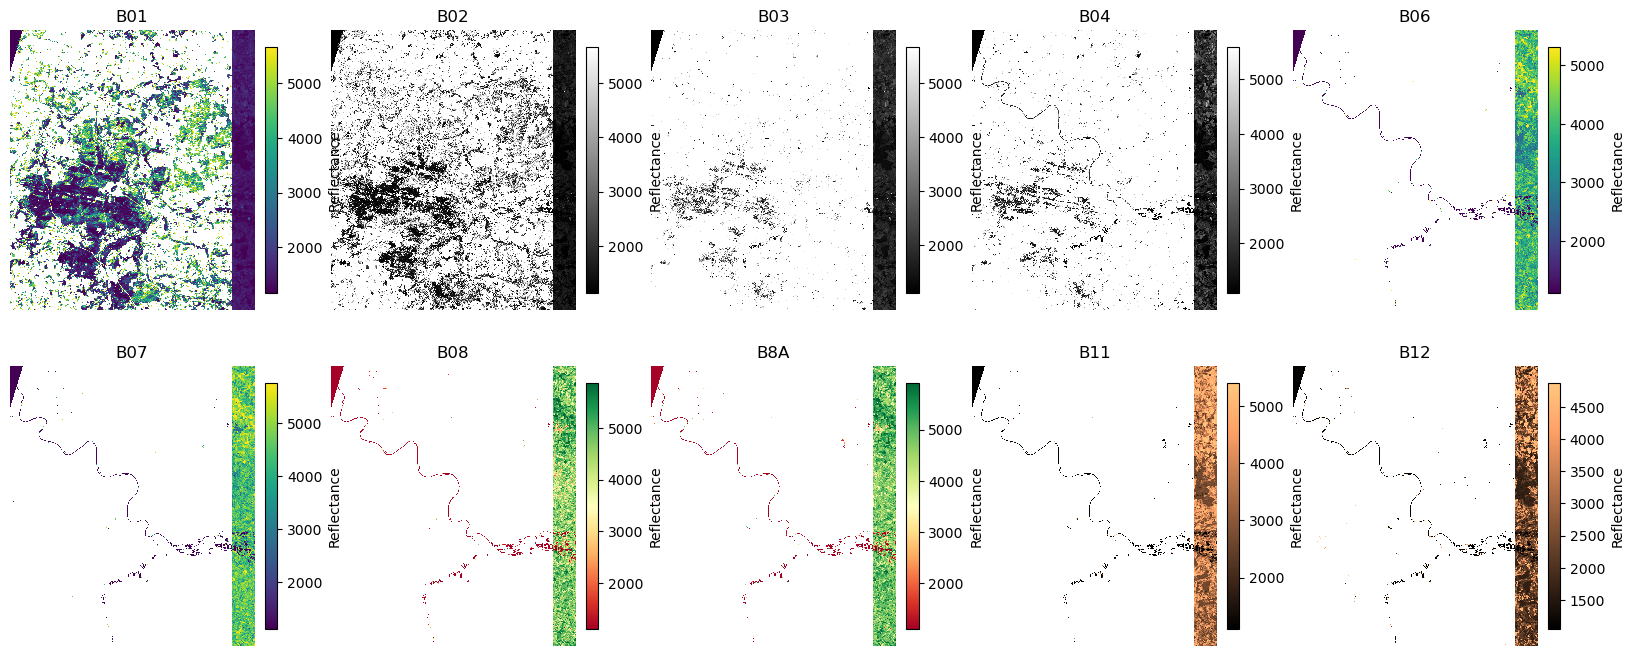

In [39]:
bands = list(raw_stack.band.values)
ncols, nrows = 5, 2
fig, axes = plt.subplots(nrows, ncols, figsize=(20, 8), squeeze=False)

for i, band in enumerate(bands):
    ax = axes[i//ncols, i % ncols]

    # pull down only this band, compute its median over time
    da = raw_stack.sel(band=band).median(dim="time").compute()

    # choose colormap
    if band in ["B02","B03","B04"]:
        cmap = "gray"
    elif band in ["B08","B8A"]:
        cmap = "RdYlGn"
    elif band in ["B11","B12"]:
        cmap = "copper"
    else:
        cmap = "viridis"

    # percentile stretch on the 2D result
    vmin, vmax = da.quantile([0.02, 0.98]).values

    im = da.plot.imshow(
        ax=ax,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        add_colorbar=False,
        add_labels=False,
        origin="upper",
    )
    cbar = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
    cbar.set_label("Reflectance")
    ax.set_title(band)
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
print(type(raw_stack))
print(raw_stack)
# Add this before creating the mask:
print("SCL unique values:", np.unique(scl.values[~np.isnan(scl.values)]))

In [ ]:
### CELL 5.5: Cloud masking + median composite 
print("Applying cloud mask and creating median composite…")

# Extract Scene Classification Layer (SCL) and build valid mask
scl = raw_stack.sel(band="SCL")
valid = scl.isin([2, 4, 5, 6, 7, 8, 9, 10, 11])  # 4=vegetation, 5=bare soil, 6=water

# Mask reflectance bands
reflectance_bands = ["B01","B02","B03","B04","B06","B07","B08","B8A","B11","B12"]
print("Applying cloud mask to reflectance bands...")
clean = raw_stack.sel(band=reflectance_bands).where(valid)

# Rechunk into smaller tiles to avoid OOM
clean = clean.chunk({"time": 1, "band": 1, "y": 512, "x": 512})

# Compute median composite
print("Computing median…")
with ProgressBar():
    composite = clean.median(dim="time").compute()

# Attach CRS and cache result
composite = composite.rio.write_crs(f"EPSG:{epsg}")

comp_cache_key = f"{base_key}_composite"
save_to_cache(composite, comp_cache_key, cache_dir)
print("✅ Composite saved to cache under key:", comp_cache_key)

print("Composite shape:", composite.shape)
print("Composite bands:", list(composite.band.values))


In [ ]:
### CELL 6: Plot all composite bands in subplots
bands = list(composite.band.values)
n = len(bands)
ncols = 5
nrows = 2

fig, axes = plt.subplots(nrows, ncols, figsize=(20, 8), squeeze=False)

for i, band in enumerate(bands):
    row = i // ncols
    col = i % ncols
    ax = axes[row, col]
    
    da = composite.sel(band=band)
    
    # Use appropriate colormap for different bands
    if band in ["B02", "B03", "B04"]:  # Blue, Green, Red
        cmap = "gray"
    elif band in ["B08", "B8A"]:  # NIR bands
        cmap = "RdYlGn"
    elif band in ["B11", "B12"]:  # SWIR bands
        cmap = "copper"
    else:
        cmap = "viridis"
    
    # Add percentile clipping to handle outliers
    vmin, vmax = da.quantile([0.02, 0.98]).values
    
    im = da.plot.imshow(
        ax=ax,
        cmap=cmap,
        add_colorbar=False,
        add_labels=False,
        origin="upper",
        vmin=vmin,
        vmax=vmax
    )
    
    cbar = fig.colorbar(im, ax=ax, orientation="vertical", fraction=0.046, pad=0.04)
    cbar.set_label("Reflectance")
    ax.set_title(f"Band {band}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [ ]:
### CELL 7: Calculate spectral indices
print("Calculating spectral indices...")

# List functions to try
funcs = [
    s2i.ndvi_s2,
    # Add more as needed:
    # s2i.hematite_goethite_s2, 
    # s2i.hematite_jarosite_s2, 
    # s2i.mixed_iron_s2,
]

results = []
for fn in tqdm(funcs, desc="Computing indices"):
    try:
        da = fn(composite)
        # Rename and add band dimension
        da = da.rename(fn.__name__)
        da = da.expand_dims("band").assign_coords({"band": [fn.__name__]})
        results.append(da)
    except Exception as e:
        print(f"Error computing {fn.__name__}: {e}")
        continue

if results:
    # Concatenate along band axis
    indices = xr.concat(results, dim="band")
    print("✅ Spectral indices computed!")
    print("Index bands:", list(indices.band.values))
else:
    print("❌ No indices computed successfully")
    indices = None

In [ ]:
### CELL 8: Plot the results (only if indices exist)
if indices is not None:
    bands = list(indices.band.values)
    n = len(bands)
    ncols = min(4, n)
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 4 * nrows), squeeze=False)

    for i, band in enumerate(bands):
        ax = axes.flat[i]
        da = indices.sel(band=band)

        cmap = ("terrain" if "clay" in band
                else "RdBu"   if "iron" in band
                else "viridis")

        # Add percentile clipping for better visualization
        vmin, vmax = da.quantile([0.02, 0.98]).values
        
        im = da.plot.imshow(
            ax=ax,
            cmap=cmap,
            add_colorbar=False,
            add_labels=False,   
            origin="upper",
            vmin=vmin,
            vmax=vmax
        )
        cbar = fig.colorbar(im, ax=ax,
                            orientation="vertical",
                            fraction=0.046, pad=0.04)
        cbar.set_label(band.replace("_"," ").title())
        ax.set_title(band.replace("_"," ").title())
        ax.axis("off")

    # Disable any empty subplots
    for j in range(n, nrows * ncols):
        r, c = divmod(j, ncols)
        axes[r][c].axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
### CELL 9: Export the results (only if indices exist)
if indices is not None:
    index_names = list(indices.band.values)
    print("Will export these indices:", index_names)

    output_dir = '/Users/thowe/Downloads'
    os.makedirs(output_dir, exist_ok=True)

    # Loop through names and export
    for name in tqdm(index_names, desc="Exporting indices"):
        try:
            da = indices.sel(band=name)
            output_path = os.path.join(output_dir, f"{name}.tif")
            da.rio.to_raster(output_path)
            print(f"✅ Exported {name}.tif")
        except Exception as e:
            print(f"❌ Error exporting {name}: {e}")

    print("✅ Export completed!")

In [ ]:
### OPTIONAL: Cache management utilities
def list_cached_composites(cache_dir):
    """List all cached composites"""
    if not os.path.exists(cache_dir):
        print("Cache directory doesn't exist")
        return
        
    cache_files = [f for f in os.listdir(cache_dir) if f.endswith('.nc')]
    print(f"Found {len(cache_files)} cached files:")
    for f in cache_files:
        cache_path = os.path.join(cache_dir, f)
        size_mb = os.path.getsize(cache_path) / (1024*1024)
        print(f"  {f}: {size_mb:.1f} MB")

def clear_cache(cache_dir):
    """Clear all cached files"""
    import shutil
    if os.path.exists(cache_dir):
        shutil.rmtree(cache_dir)
        os.makedirs(cache_dir, exist_ok=True)
        print("Cache cleared!")


In [ ]:

# Example usage:
# list_cached_composites(cache_dir)
# clear_cache(cache_dir)  # Use with caution!